In [1]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")

using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [2]:
function get_vf_for_parameters(params)
    a1, b1, a2, b2, c1, c2 = params
    f(u1, u2) =    [-a1 * u1 + b1*(c1-u1)*u2
                    -a2 * u2 + b2*(c2-u2)*u1]
    return f
end

get_vf_for_parameters (generic function with 1 method)

Solving ODE from x0=[0.4, 0.1]
size(sol) = (2, 11)
length = 10


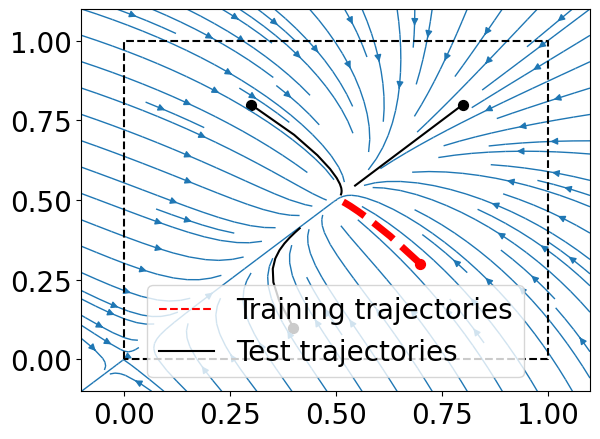

Solving ODE from x0=[0.8, 0.8]
size(sol) = (2, 8)
length = 10
Solving ODE from x0=[0.3, 0.8]
size(sol) = (2, 11)
length = 10
Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10)
length = 10


PyObject <matplotlib.legend.Legend object at 0x7f7588515be0>

In [3]:
gr(size=(600,400))


ode_p = [.05 .1 .05 .1 1. 1.]
ff = get_vf_for_parameters(ode_p)

plot_vectorfield(ff, (-0.1, 1.1, 50), (-0.1, 1.1, 50))

initial_conditions = [ [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in initial_conditions[2:end]
    sol = solve_ode(ff, x0, tspan = (0., 30.0))
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end

x0 = initial_conditions[1]
sol = solve_ode(ff, x0)
PyPlot.plot(sol..., color=:red, ls="--", lw=5)
PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:black, label="Test trajectories")
plot_box()
PyPlot.legend()


In [4]:
function get_training_data(x0; noise_level=1e-6, verbose=true, length=10)
    Random.seed!(0)
    training_x = hcat(solve_ode(ff, x0; verbose=verbose, length=length)...)'
    training_xdot = ff.(training_x[1, :], training_x[2, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    return training_x, training_xdot
end


∞ = 1e9
function test_error(vf, initial_conditions; verbose=false)
    penalty = u -> sum(u.^2)
    error = 0
    for x0 in initial_conditions
        sol = []
        try
            sol = solve_ode(vf, x0, verbose=verbose)
        catch y
            return ∞
        end
        true_sol =  solve_ode(ff, x0, verbose=verbose)
        for  i=1:size(sol, 1)
            error += penalty(sol[i] .- true_sol[i])
        end
        if verbose
            println("at $x0, error = $error")
        end
    end
    return error / size(initial_conditions, 1)
end

# should ne 0
test_error(ff, initial_conditions[2:end])


0.0

In [32]:
box_invariance(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
#     # p2(x2=0) >= 0
#     @variable(model, s1[1:2], Poly([1, x1, x1^2]))
#     @constraint model s1[1] in SOSCone()
#     @constraint model s1[2] in SOSCone()
#     @constraint model coefficients(subs(p[2], x2=>0) - x1 * s1[1] - (1-x1) * s1[2]) .== 0
    
#     #p2(x2=1) <= 0
#     @variable(model, s2[1:2], Poly([1, x1, x1^2]))
#     @constraint model s2[1] in SOSCone()
#     @constraint model s2[2] in SOSCone()
#     @constraint model coefficients(subs(-p[2], x2=>1) - x1 * s2[1] - (1-x1) * s2[2]) .== 0
    
    
    
#      # p1(x1=0) >= 0
#     @variable(model, r1[1:2], Poly([1, x2, x2^2]))
#     @constraint model r1[1] in SOSCone()
#     @constraint model r1[2] in SOSCone()
#     @constraint model coefficients(subs(p[1], x1=>0) - x2 * r1[1] - (1-x2) * r1[2]) .== 0
    
#      # p1(x1=1) <= 0
#     @variable(model, r2[1:2], Poly([1, x2, x2^2]))
#     @constraint model r2[1] in SOSCone()
#     @constraint model r2[2] in SOSCone()
#     @constraint model coefficients(subs(-p[1], x1=>1) - x2 * r1[1] - (1-x2) * r1[2]) .== 0
    
   
    int_y = @set x2 >= 0 && 1 - x2 >= 0
    int_x = @set x1 >= 0 && 1 - x1 >= 0

    @constraint(model, subs(p1, x1=>0) >= 0, domain=int_y )
    @constraint(model, -subs(p1, x1=>1) >= 0, domain=int_y )
    @constraint(model, subs(p2, x2=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p2, x2=>1) >= 0, domain=int_x )
end


monotonicity(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
#     g = [1, 1 - x1,  x2, 1 - x2, x2]
#     p1, p2 = p
#     @variable(model, σ[1:2, 1:size(g,1)], Poly(monomials([x1, x2], 0:2)))
#     @constraint model σ .>= 0
#     @constraint model vcat(coefficients.([differentiate(p1, x2), differentiate(p2, x1)] .- σ * g)...) .== 0


    Box = @set 1 - x1 >=  0 && x1 >= 0 && 1 - x2 >= 0 && x2 >= 0
    @constraint(model, differentiate(p1, x2) >= 0, domain=Box)
    @constraint(model, differentiate(p2, x1) >= 0, domain=Box)
end

equilibrium_points(model, p, x) = begin
    @constraint model p[1](0, 0) == 0
    @constraint model p[2](0, 0) == 0
end

equilibrium_points (generic function with 1 method)

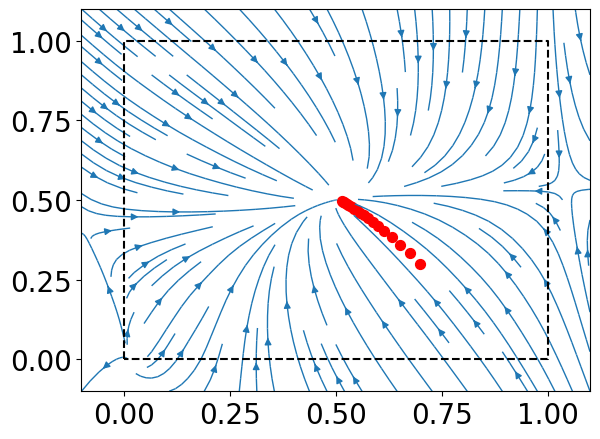

Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10)
length = 10
n = 2
size(training_xdot) = (2, 20)
size(training_x) = (2, 20)
deg = 3
solver = MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawParameter("QUIET") => true])
Define polynomial variable
Define p(training)
side_info = Dict{String, Function}("equilibrium_points" => equilibrium_points, "box_invariance" => box_invariance, "monotonicity" => monotonicity)
Imposing equilibrium_points
Imposing box_invariance
Imposing monotonicity
Define objective
Solving
value(objective) = 0.0005316738105494315
round.(p_opt, digits = 2) = Polynomial{true, Float64}[0.29x₁³ + 0.05x₁²x₂ - 0.12x₁x₂² - 0.44x₁² + 0.03x₁x₂ + 0.08x₂² + 0.11x₁, 0.18x₁x₂² + 0.05x₂³ - 0.27x₁x₂ - 0.23x₂² + 0.1x₁ + 0.09x₂]
round.(opt_value, digits = 6) = 0.000532


In [35]:
verbose = true
deg = 3
noise_level=1e-2
data_x, data_y = get_training_data(initial_conditions[1], noise_level=noise_level, 
     verbose=verbose, length=10)
data_x = [0.7 0.6743 0.651733 0.631992 0.614775 0.599795 0.586786 0.575503 0.565731 0.557274 0.549955 0.543627 0.538154 0.533421 0.529324 0.525778 0.522708 0.520048 0.517738 0.515732; 0.3 0.332724 0.360048 0.382911 0.402075 0.418161 0.431681 0.443055 0.452628 0.460689 0.46748 0.473199 0.478011 0.482062 0.485469 0.488331 0.490729 0.492736 0.494415 0.495815]
data_y = [-0.0259321 -0.0229135 -0.0199887 -0.0175017 -0.0153012 -0.0133236 -0.0114618 -0.0100023 -0.00879107 -0.00724013 -0.00647079 -0.00547157 -0.00480303 -0.00421488 -0.00358632 -0.00298889 -0.00265446 -0.00228428 -0.00204884 -0.00161675; 0.0340828 0.0283447 0.0237351 0.0198431 0.0168126 0.013914 0.0118452 0.00988082 0.00808706 0.00704187 0.00585207 0.00496953 0.00420161 0.00357221 0.00288563 0.00252677 0.00205396 0.00179401 0.00127819 0.00135135]
training_x = data_x
training_xdot = data_y


side_info = Dict(
    "equilibrium_points" => equilibrium_points,
    "box_invariance" => box_invariance,
    "monotonicity" => monotonicity,
 )

p_opt, opt_value = 
fit_polynomial_to_data_with_side_info(training_x, training_xdot; 
    side_info=side_info, verbose=verbose, deg=deg, regularization=0.)
@show round.(p_opt, digits=2)
@show round.(opt_value, digits=6)

p_opt_as_f = (a, b) ->  map(pi -> pi([a,b]), p_opt)
plot_vectorfield(p_opt_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
PyPlot.scatter(data_x[1,:], data_x[2, :], color=:red, s=50)
plot_box();


In [36]:
p_opt

2-element Vector{Polynomial{true, Float64}}:
 0.28783858888779046x₁³ + 0.05298908728259631x₁²x₂ - 0.12306419040073567x₁x₂² - 0.4381582325389076x₁² + 0.02803978295569106x₁x₂ + 0.08267463132193255x₂² + 0.10950103230426371x₁ + 2.50732835106297e-5x₂
 -0.001719051303536786x₁²x₂ + 0.17822806749588282x₁x₂² + 0.048227091999199244x₂³ + 0.00129335427215614x₁² - 0.26733147702853155x₁x₂ - 0.23078738681675265x₂² + 0.10031494494789148x₁ + 0.09279073647079697x₂

In [49]:
p_opt_as_f = (a, b) ->  map(pi -> pi([a,b]), p_opt)
tracking_error = test_error(p_opt_as_f, initial_conditions[2:end], verbose=false)
println("Least squares fit: $opt_value, test_error $tracking_error")

Least squares fit: 0.0004270616856077832, test_error 0.09895388278217379
